## Prelude

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tables as tb

from pathlib import Path
from matplotlib import cm
from math import isnan

For convenience we define a binary-wise color palette for `seaborn` plots.

In [2]:
sns_palette = {'BHBH' : sns.color_palette()[3], 
               'BHNS' : sns.color_palette()[-1], 
               'NSBH' : sns.color_palette()[6], 
               'NSNS' : sns.color_palette()[2]}

Stellar types number ID convention used by COMPAS, from

In [3]:
stellar_types = {'0' : 'MS<0.7',
                 '1' : 'MS>0.7',
                 '2' : 'HG',
                 '3' : 'GB',
                 '4' : 'CHeB',
                 '5' : 'EAGB',
                 '6' : 'TPAGB',
                 '7' : 'HeMS',
                 '8' : 'HeHG',
                 '9' : 'HeGB',
                 '10': 'HeWD',
                 '11': 'COWD',
                 '12': 'ONeWD',
                 '13': 'NS',
                 '14': 'BH',
                 '15': 'massless',
                 '16': '16',
                 '17': '17',
                 '18': '18',
                 '19': '19'}

Below are some utility functions for data processing.

In [4]:
def chirp_mass(row):
    """Calculate the chirp mass for a dataframe row."""    
    m1 = row['Mass(1)']
    m2 = row['Mass(2)']
    return (m1*m2)**(3/5)/(m1+m2)**(1/5)

def bintype2(bintype):
    """Translate the binary type from numeric ID to a string abbreviation."""
    t1, t2 = bintype.split('+')
    return stellar_types[t1]+stellar_types[t2]

def symmetrized_q(m1,m2):
    """Calculate the mass ratio q as greater mass/lesser mass."""
    if m1 > m2:
        return m2/m1
    else:
        return m1/m2
    
def symmetrize_masses(row):
    """Switch the Mass(1) and Mass(2) columns of a dataframe row if Mass(2) is greater."""
    if row['Mass(1)'] > row['Mass(2)']:
        return row['Mass(1)'], row['Mass(2)']
    else:
        return row['Mass(2)'], row['Mass(1)']

The following list contains the columns that should be saved and passed to the classification notebook.

In [5]:
classification_columns = ['Mass(1)', 'Mass(2)', 'Total_Mass@DCO', 'Chirp_Mass', 'Redshift@Merger']

## Loading data

Here we define the path of the COMPAS output files to be loaded. Remember to set these properly to your file structure. We opt to use the `pathlib` library to set the paths because this assures everything will work on any OS (otherwise, we would have to watch out for \ instead of / in Windows, for example).

In [6]:
ROOT = Path('..')
DATA_FOLDER = Path(ROOT, 'Data')
OUTPUT_FOLDER1 = Path(DATA_FOLDER, 'IMFgrid2_results')
OUTPUT_FOLDER2 = Path(DATA_FOLDER, 'IMFgrid3_results')

output_paths = list(OUTPUT_FOLDER1.glob('COMPAS_Output*/COMPAS_Output.h5'))+list(OUTPUT_FOLDER2.glob('COMPAS_Output*/COMPAS_Output.h5'))
label_paths = list(OUTPUT_FOLDER1.glob('COMPAS_Output*/compas_grid*.txt'))+list(OUTPUT_FOLDER2.glob('COMPAS_Output*/compas_grid*.txt'))

The `output_paths` list contains the path of the output files themselves, while `label_paths` contains the COMPAS grid file that specifies the initial sample to be evolved. The grid files store the unique metallicity and redshift that identify each sample in their title; because the redshift doesn't influence the evolution itself, it's not one of COMPAS' parameters. Because of that, we need to get it from the grid file title.

Since this is not a general analysis notebook, we'll only load the attributes needed by the classification algorithms, and those which are relevant for setting the merger redshift and calculating selection effects.

In [7]:
DCOtable_columns_to_load = ['SEED', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Coalescence_Time']
SysParam_table_columns_to_load = ['Metallicity@ZAMS(1)']
SNtable_columns_to_load = []

Below we define a function that loads the specified columns from all of the output files within the `output_files` list into a dictionary with the same structure as the .h5 files.

In [8]:
def COMPASoutput_to_dict():
    catalog = {}

    for path, label in zip(output_paths, label_paths):
        print(f'Now loading {path}')
    
        table = tb.open_file(path, 'r')
    
        # In some cases COMPAS simply did not evolve the sample from the grid file. It is not clear
        # why, but these cases can be identified by a missing BSE_System_Parameters group in the
        # h5 file. Below we catch and skip these cases, after warning the user about which file had
        # this issue.
        if not table.root.__contains__('BSE_System_Parameters'):
            print(f'Output {path} seems to be broken.')
            print('')
            continue
    
    
        # Here we get the metallicity and redshift from the grid file title.
        z = label.stem.split('_')[2].lstrip('z')
        Z = label.stem.split('_')[3].lstrip('Z')
    
        # A partial catalog is the dict from a single output file.
        partial_catalog = {}
    
        # These are the tables from which we load data.
        DCOtable = table.root.BSE_Double_Compact_Objects
        SNtable = table.root.BSE_Supernovae
        SysParam_table = table.root.BSE_System_Parameters
    
        # The SEED is a unique identifier for each binary within the same sample. Because we are only
        # interested in the DCOs, we store all the seeds from the DCO table and then look for them
        # in the other tables, which also contain non-DCO binaries.
        seeds = list(DCOtable.SEED)
        N = len(seeds)

        # In the three following loops, we iterate over each table. For each row, we first check if the
        # seed is that of a DCO, i.e., if it was in the DCO table. If the row contains a DCO seed, then
        # we load the columns previosly specified in the to_load lists. An 'if' makes sure to first
        # create the corresponding column with the approppriate size in the dictionary if it doesn't 
        # exist yet, before filling it.
        print('Loading Double Compact Objects table...')
        for i, seed in enumerate(DCOtable.SEED):
            if seed in seeds:
                for column in DCOtable_columns_to_load:
                    if column not in partial_catalog:
                        partial_catalog[column] = np.empty(N, np.float64)
                    partial_catalog[column][i] = DCOtable[column][i]
            
        print('Loading System Parameters table...')
        for i, seed in enumerate(SysParam_table.SEED):
            if seed in seeds:
                index = seeds.index(seed)
                for column in SysParam_table_columns_to_load:
                    if column not in partial_catalog:
                        partial_catalog[column] = np.empty(N, np.float64)
                    partial_catalog[column][index] = SysParam_table[column][i]
    
        print('Loading Supernovae table...')
        for i, seed in enumerate(SNtable.SEED):
            if seed in seeds:
                index = seeds.index(seed)
                for column in SNtable_columns_to_load:
                    if column not in partial_catalog:
                        partial_catalog[column] = np.empty(N, np.float64)
                    partial_catalog[column][index] = SNtable[column][i]
    
        table.close()
    
        # The seeds are unique identifiers within each sample, but not between different samples. In order
        # for each binary to be uniquely identifiable within the entire sample, we add to the seed the 
        # redshift and metallicity of the sample it was evolved in. Thus the final seeds are of the format
        # original seed + 00 + metallicity + 00 + redshift.
        print('Fixing seeds...')
        partial_catalog['Redshift@ZAMS'] = []
        for index, seed in enumerate(partial_catalog['SEED']):
            new_seed = int(str(int(seed)) + '00' + Z + '00' + z)
            partial_catalog['SEED'][index] = new_seed
            partial_catalog['Redshift@ZAMS'].append(int(z)/100)
        
        # Once each binary has received a unique identifier, the full catalog is update with the current one.
        for item in partial_catalog:
            if item not in catalog:
                catalog[item] = []
            catalog[item] += list(partial_catalog[item])
        print('Done.')
        print('')
    
    print('Table loaded.')
    return catalog

In [9]:
catalog_dict = COMPASoutput_to_dict()

Now loading ..\Data\IMFgrid2_results\COMPAS_Output\COMPAS_Output.h5
Loading Double Compact Objects table...
Loading System Parameters table...
Loading Supernovae table...
Fixing seeds...
Done.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_1\COMPAS_Output.h5
Loading Double Compact Objects table...
Loading System Parameters table...
Loading Supernovae table...
Fixing seeds...
Done.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_10\COMPAS_Output.h5
Loading Double Compact Objects table...
Loading System Parameters table...
Loading Supernovae table...
Fixing seeds...
Done.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_11\COMPAS_Output.h5
Output ..\Data\IMFgrid2_results\COMPAS_Output_11\COMPAS_Output.h5 seems to be broken.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_12\COMPAS_Output.h5
Loading Double Compact Objects table...
Loading System Parameters table...
Loading Supernovae table...
Fixing seeds...
Done.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_13\COMP

#### Dataframe setup

In [10]:
catalog_df = pd.DataFrame(catalog_dict)

Imposing $ m_1>m_2 $,

In [11]:
for index, row in catalog_df.iterrows():
    m1 = row['Mass(1)']
    m2 = row['Mass(2)']
    if m1 < m2:
        catalog_df.loc[index, 'Mass(1)'] = m2
        catalog_df.loc[index, 'Mass(2)'] = m1

Now there's a bit of data manipulation to be done. First we get the binary type for each object in the catalog.

In [12]:
catalog_df['Stellar_Type(1)'] = catalog_df['Stellar_Type(1)'].apply(int)
catalog_df['Stellar_Type(2)'] = catalog_df['Stellar_Type(2)'].apply(int)
catalog_df['Binary_Type'] = (catalog_df['Stellar_Type(1)'].apply(str)+'+'+ catalog_df['Stellar_Type(2)'].apply(str)).apply(bintype2)

Then the total mass, chirp mass and mass ratio.

In [13]:
catalog_df['Chirp_Mass'] = catalog_df.apply(chirp_mass, axis=1)
catalog_df['Total_Mass@DCO'] = catalog_df['Mass(1)']+catalog_df['Mass(2)']
catalog_df['Mass_Ratio@DCO'] = catalog_df.apply(lambda x: symmetrized_q(x['Mass(1)'], x['Mass(2)']), axis=1)

It is also more convenient to standardize times as measured in years (COMPAS uses Myr) and to store the seed as an integer rather than a string.

In [14]:
catalog_df['Coalescence_Time'] = 1e6*catalog_df['Coalescence_Time'] # time in years
catalog_df['SEED'] = catalog_df['SEED'].apply(int)

We can now have an overview of the initial catalog.

In [15]:
catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22597 entries, 0 to 22596
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SEED                 22597 non-null  uint64 
 1   Mass(1)              22597 non-null  float64
 2   Mass(2)              22597 non-null  float64
 3   Merges_Hubble_Time   22597 non-null  float64
 4   Stellar_Type(1)      22597 non-null  int64  
 5   Stellar_Type(2)      22597 non-null  int64  
 6   Coalescence_Time     22597 non-null  float64
 7   Metallicity@ZAMS(1)  22597 non-null  float64
 8   Redshift@ZAMS        22597 non-null  float64
 9   Binary_Type          22597 non-null  object 
 10  Chirp_Mass           22597 non-null  float64
 11  Total_Mass@DCO       22597 non-null  float64
 12  Mass_Ratio@DCO       22597 non-null  float64
dtypes: float64(9), int64(2), object(1), uint64(1)
memory usage: 2.2+ MB


In [16]:
catalog_df.describe()

,SEED,Mass(1),Mass(2),Merges_Hubble_Time,Stellar_Type(1),Stellar_Type(2),Coalescence_Time,Metallicity@ZAMS(1),Redshift@ZAMS,Chirp_Mass,Total_Mass@DCO,Mass_Ratio@DCO
count,2.259700e+04,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000,2.259700e+04,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000
mean,2.304214e+18,13.766566,10.382250,0.313227,13.633580,13.595610,9.177552e+25,0.006763,1.000521,10.154606,24.148816,0.798081
std,4.838654e+18,11.808161,9.918775,0.463816,0.481837,0.490784,9.492262e+26,0.007233,0.565480,9.141687,21.157135,0.257478
min,1.639654e+15,1.260000,1.260000,0.000000,13.000000,13.000000,6.973498e-01,0.000200,0.010000,1.096894,2.520000,0.028319
25%,1.639430e+17,1.260240,1.260000,0.000000,13.000000,13.000000,4.405098e+09,0.000200,0.610000,1.096998,2.520240,0.662786
50%,1.639723e+17,14.870794,8.037318,0.000000,14.000000,14.000000,5.132760e+12,0.006325,1.000000,9.510499,24.769052,0.924357
75%,1.639449e+18,22.101827,16.813219,1.000000,14.000000,14.000000,3.576578e+21,0.006325,1.400000,16.745117,39.083311,0.999899
max,1.639529e+19,144.262443,43.827681,1.000000,14.000000,14.000000,6.165767e+28,0.020000,1.800000,38.154213,150.258862,1.000000


But since we are only interested in merging systems, we can drop the rest right away.

In [17]:
mcatalog_df = catalog_df[(catalog_df['Merges_Hubble_Time']==1)]
mcatalog_df.reset_index(drop=True, inplace=True)

A bit of cleanup is order. Because all systems in `mcatalog_df` have `Merges_Hubble_Time` as 1, we can drop that column. Because we have `Binary_Type`, we also don't need the `Stellar_Type(1)` and `Stellar_Type(2)` columns.

In [18]:
mcatalog_df.drop('Merges_Hubble_Time', axis=1, inplace=True)
mcatalog_df.drop('Stellar_Type(1)', axis=1, inplace=True)
mcatalog_df.drop('Stellar_Type(2)', axis=1, inplace=True)

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We also rename "Coalescence Time" to "Delay Time" in order to conform to the most common naming convention. The following figure from Broekgaarden et al. (2021) nicely explains the different times we will be discussing in the next section (10 is an assumed redshift for the beginning of star formation).

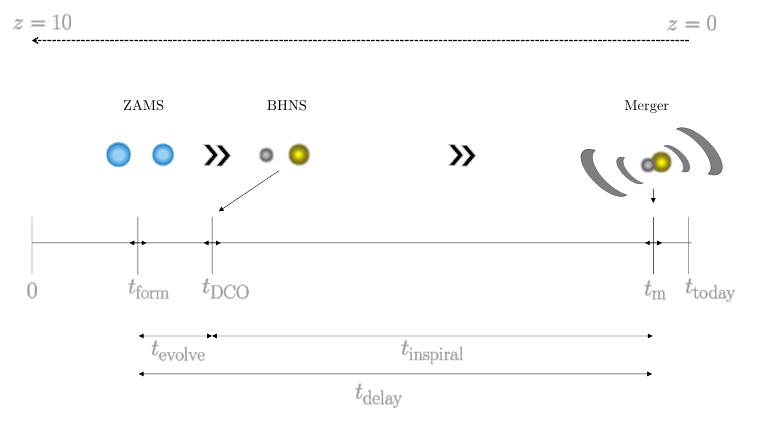

In [19]:
mcatalog_df.rename(columns={'Coalescence_Time' : 'Delay_Time'});

Let's have a look at our catalog so far.

In [20]:
mcatalog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7078 entries, 0 to 7077
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SEED                 7078 non-null   uint64 
 1   Mass(1)              7078 non-null   float64
 2   Mass(2)              7078 non-null   float64
 3   Coalescence_Time     7078 non-null   float64
 4   Metallicity@ZAMS(1)  7078 non-null   float64
 5   Redshift@ZAMS        7078 non-null   float64
 6   Binary_Type          7078 non-null   object 
 7   Chirp_Mass           7078 non-null   float64
 8   Total_Mass@DCO       7078 non-null   float64
 9   Mass_Ratio@DCO       7078 non-null   float64
dtypes: float64(8), object(1), uint64(1)
memory usage: 553.1+ KB


In [21]:
mcatalog_df.describe()

,SEED,Mass(1),Mass(2),Coalescence_Time,Metallicity@ZAMS(1),Redshift@ZAMS,Chirp_Mass,Total_Mass@DCO,Mass_Ratio@DCO
count,7.078000e+03,7078.000000,7078.000000,7.078000e+03,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000
mean,2.695086e+18,8.879345,6.360025,2.402964e+09,0.007375,0.961474,6.327226,15.239369,0.802949
std,5.371063e+18,10.591414,9.458333,3.297589e+09,0.007880,0.567578,8.494990,19.664114,0.278789
min,1.639655e+15,1.260000,1.260000,6.973498e-01,0.000200,0.010000,1.096894,2.520000,0.073258
25%,1.639420e+17,1.260183,1.260000,1.947055e+08,0.000200,0.410000,1.096973,2.520183,0.595043
50%,1.639721e+17,1.424122,1.260000,7.806284e+08,0.006325,1.000000,1.165702,2.684122,0.999734
75%,1.639454e+18,15.166484,7.221274,3.438195e+09,0.020000,1.400000,8.787651,22.408483,0.999912
max,1.639529e+19,43.835244,43.827681,1.399353e+10,0.020000,1.800000,38.154213,87.655363,1.000000


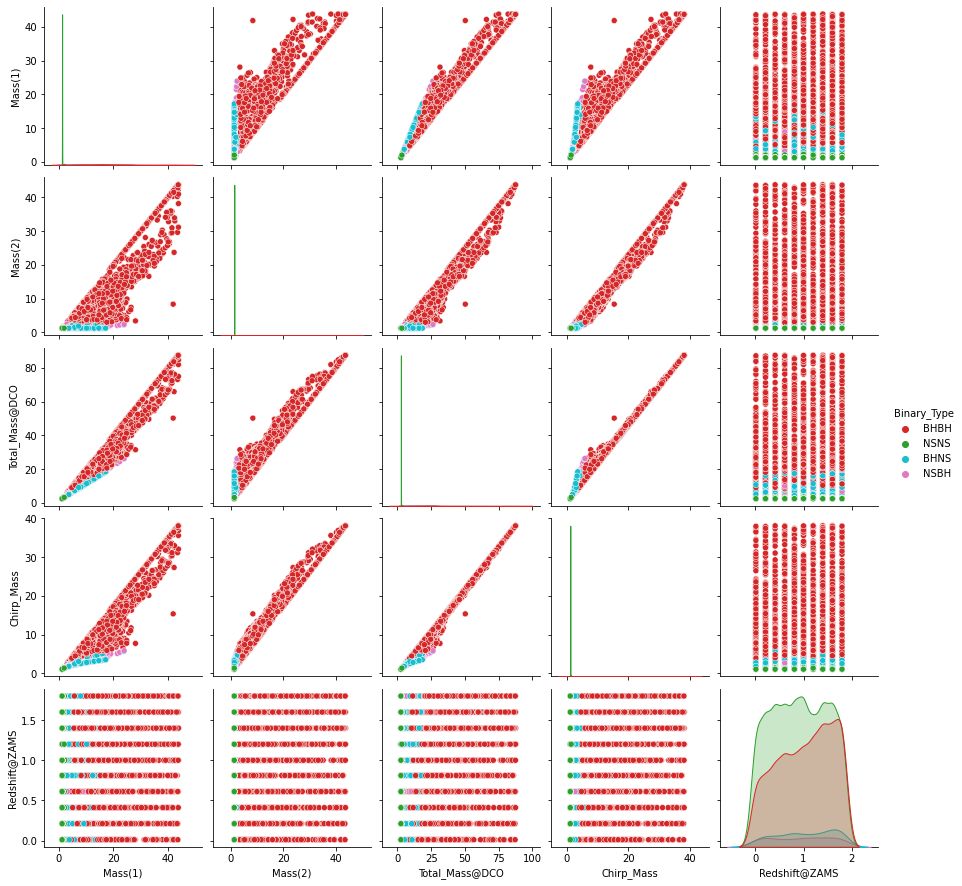

In [22]:
columns_to_plot = classification_columns+['Redshift@ZAMS', 'Binary_Type']
columns_to_plot.remove('Redshift@Merger')
sns.pairplot(mcatalog_df[columns_to_plot], hue='Binary_Type', palette=sns_palette)

Notice how the redshift is still completely discretized and shows essentially no correlation with any quantities. This is because we sampled all masses and initial separations for every redshift and COMPAS puts every system at $ z=0 $ in order to determine whether it merges within a Hubble time or not. In reality, not only are lighter systems harder to detect upon merger, the lower the redshift, the less time the binary has to merge in order to be observed in the present, which immediately implies a correlation between the redshift _at merger_ and the mass of the lightest observable binary. In order to account for this, we need to first correct our catalog for the actual time of formation of each binary, and then apply selection effects.

## Selection Effects

Let's now account for selection effects in order to create a catalog that represents what might actually be observed by LIGO.

In order to work with `astropy`, we'll need the coalescence/delay times in Gyr.

In [23]:
mcatalog_df['Coalescence_Time'] = mcatalog_df['Coalescence_Time'].apply(lambda x: x/1e9)

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Calculating the merger time and eliminating too young binaries

We'll now correct each system for `Redshift@ZAMS`. This is necessary because COMPAS determines whether the systems merges within $ t_H $ by assuming $ z=0 $. Because each of our systems is supposed to have been born at a particular redshift $ z_\mathrm{form} $, for which there is a time of formation $ t_\mathrm{form} $, we need to check whether the binary has actually had enough time to merge so far. In order to do this, we need to first calculate $ t_\mathrm{form} $, then check if the merger time $ t_\mathrm{m}=t_\mathrm{form}+t_\mathrm{d} $ is less than the age of the Universe. The figure above should help make the relation between the different times clear.

In order to do this, we need to assume a cosmology. The `astropy` package provides us with a few different choices from the WMAP and Planck data. In keeping with Neijssel et al. (2019), we employ here the WMAP9 cosmology from Hinshaw et al. (2013). All available choices can be found [here](https://docs.astropy.org/en/stable/cosmology/index.html#built-in-cosmologies), and the import below can be freely switched between them without any changes in the rest of the notebook.

In [24]:
from astropy.cosmology import WMAP9 as cosmo

Next we define a function that will compute a `Merger_Time` column from the `Redshift@ZAMS` and `Delay_Time`. Then we apply it to our catalog.

In [25]:
def merger_time(df):
    t_d = df.Coalescence_Time
    z = df['Redshift@ZAMS']
    birth_time = cosmo.age(z).value #Gyr
    merger_time = birth_time + t_d
    df['Merger_Time'] = merger_time
    return df

In [26]:
mcatalog_df = merger_time(mcatalog_df)

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


As we can see below, even if the first stars had been born at $ t_\mathrm{form}=0 $, many of the systems in the catalog are too young to have already merged. Not surprisingly, almost none of the systems born at $ z=0.01 $ have yet had time to merge.

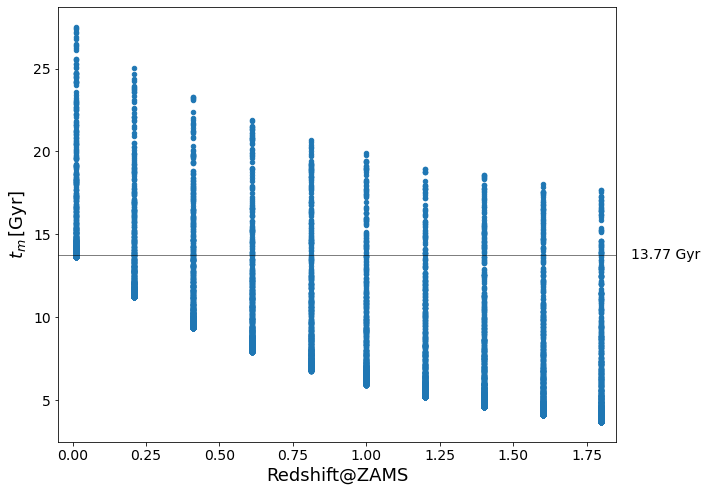

In [27]:
fig, ax = plt.subplots(figsize=(10,8))

universe_age = cosmo.age(0).value
mcatalog_df.plot.scatter(x='Redshift@ZAMS', y='Merger_Time', ax=ax)
ax.hlines(universe_age, -0.05, 2, 'k', lw=0.5)
ax.set_xlim(-0.05, 1.85)
ax.text(1.9, 13.5, f'{universe_age:.2f} Gyr', fontsize=14)
ax.set_ylabel(r'$t_m\,[\mathrm{Gyr}]$', fontsize=18)
ax.set_xlabel('Redshift@ZAMS', fontsize=18)
ax.tick_params(axis='both', labelsize=14)


We can now exclude from our catalog the systems that would have to be older than the universe for them to have already merged.

In [28]:
def remove_too_young_binaries(df):
    df = df.drop(df[df.Merger_Time > universe_age].index)
    df.reset_index(drop=True, inplace=True)
    return df

In [29]:
LIGOcatalog_df = remove_too_young_binaries(mcatalog_df)

Looks good.

<AxesSubplot:xlabel='Redshift@ZAMS', ylabel='Merger_Time'>

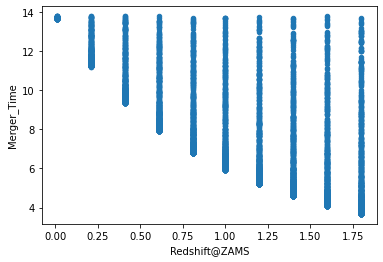

In [30]:
LIGOcatalog_df.plot.scatter(x='Redshift@ZAMS', y='Merger_Time')

For the selection effects, however, the relevant redshift is the redshift _at merger_, $ z_m $. This means we now must take the merger time of each system and convert it back to a redshift. While `astropy` can efficiently calculate the age from the redshift, calculating the redshift from age is not as simple. The CosmicIntegration code does this by using a precalculated age-redshift table and finding the nearest age to the $ t_m $ of the system in question. The CosmicIntegration notebook, on the other hand, uses the Newton-Raphson method to solve $ f(z_m) = t(z_m) - t_m = 0 $, a slower method. For brevity, we will simply reproduce the latter method here.

In [31]:
from scipy.optimize import newton

In [32]:
merger_times = LIGOcatalog_df.Merger_Time.to_numpy()
merger_redshifts = np.zeros(merger_times.shape[0])
for i, time in enumerate(merger_times):
    merger_redshifts[i] = newton(lambda x: cosmo.age(x).value - time, 0)
    
LIGOcatalog_df['Redshift@Merger'] = merger_redshifts

We can see now how much the binaries tend to shift redshifts between birth and merger by plotting a histogram of the redshift at merger for each value of redshift at birth.

In [33]:
formation_redshifts = np.unique(LIGOcatalog_df['Redshift@ZAMS'].to_numpy())
print(len(formation_redshifts), formation_redshifts)

10 [0.01 0.21 0.41 0.61 0.81 1.   1.2  1.4  1.6  1.8 ]


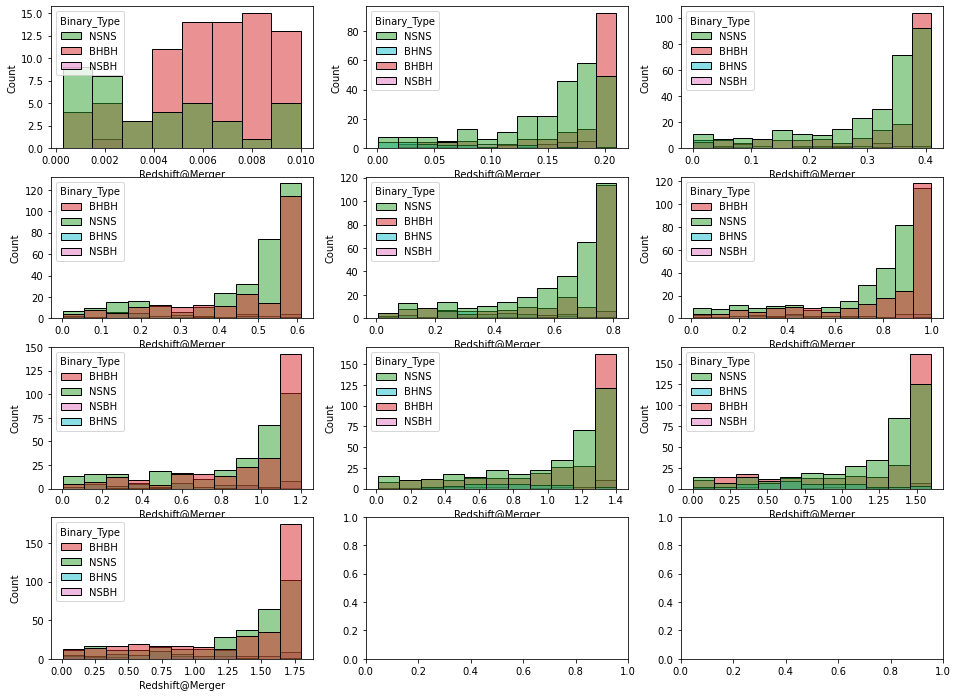

In [34]:
fig, axes = plt.subplots(4, 3, figsize=(16,12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    try:
        subcatalog = LIGOcatalog_df[LIGOcatalog_df['Redshift@ZAMS'] == formation_redshifts[i]]
        sns.histplot(subcatalog, x='Redshift@Merger', hue='Binary_Type', ax=ax, palette=sns_palette)
    except IndexError:
        continue

It's interesting to express the redshift at merger as a fraction of the redshift at birth.

In [35]:
LIGOcatalog_df['Fraction_to_Merge'] = LIGOcatalog_df['Redshift@Merger']/LIGOcatalog_df['Redshift@ZAMS']

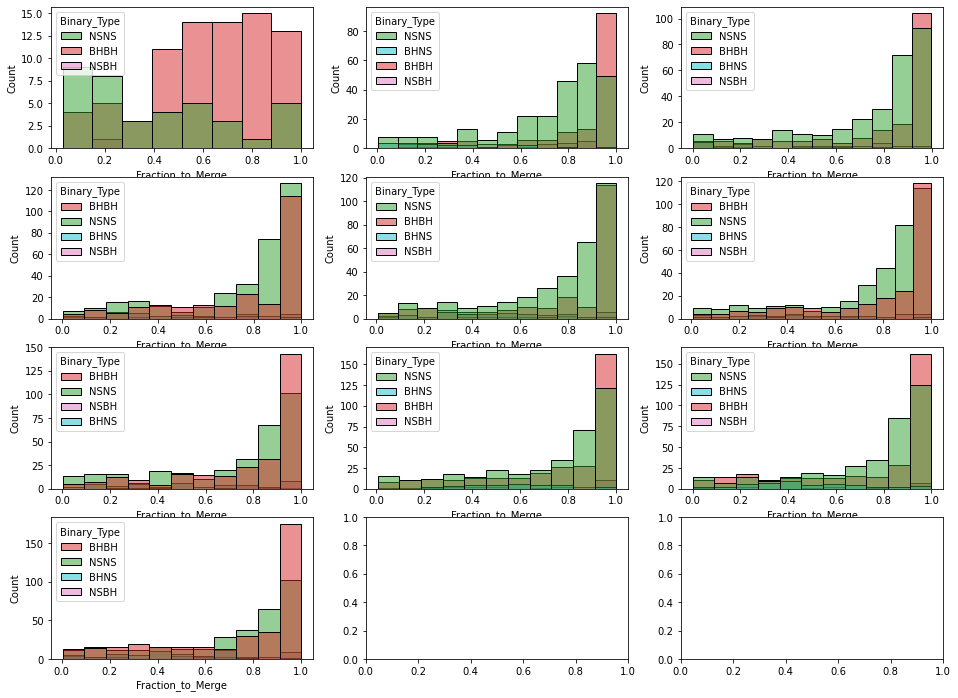

In [36]:
fig, axes = plt.subplots(4, 3, figsize=(16,12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    try:
        subcatalog = LIGOcatalog_df[LIGOcatalog_df['Redshift@ZAMS'] == formation_redshifts[i]]
        sns.histplot(subcatalog, x='Fraction_to_Merge', hue='Binary_Type', ax=ax, palette=sns_palette)
    except IndexError:
        continue

It seems that most systems tend to stay within 2/3 of the redshift at birth, as long as it is not too low.

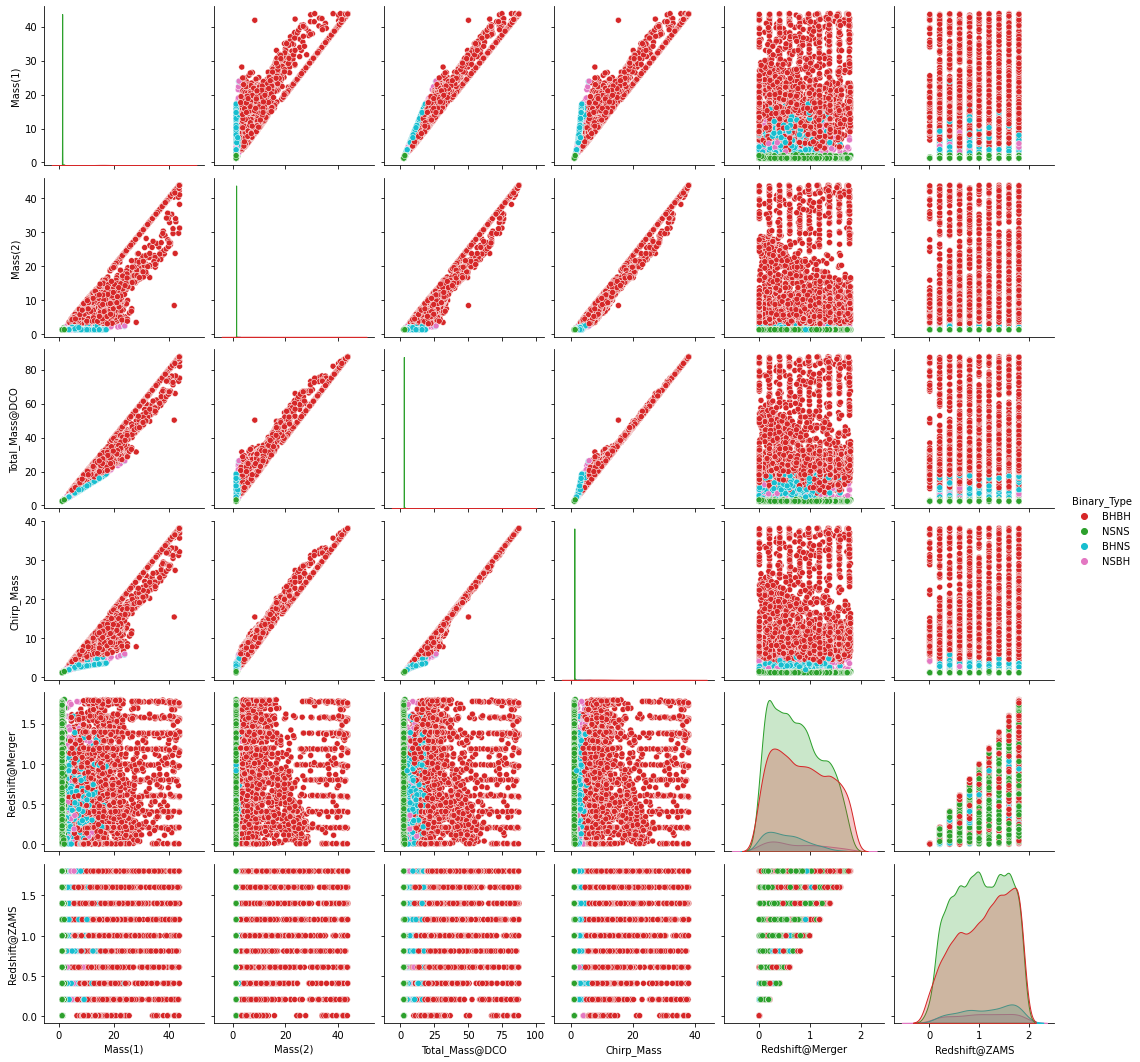

In [37]:
columns_to_plot = classification_columns+['Redshift@ZAMS', 'Binary_Type']
sns.pairplot(LIGOcatalog_df[columns_to_plot], hue='Binary_Type', palette=sns_palette)

Notice how the redshift at merger starts to show a correlation with mass as a consequence of binary evolution, and particularly the rate of energy loss through gravitational radiation of each system. On the other hands, the discretized lines are still clearly visible;

#### Luminosity distance

CosmicIntegration's detection probability function also requires the luminosity distance. With an assumed cosmology, `astropy` provides a quick way to compute the luminosity distance from redshfit.

In [38]:
def luminosity_distance(z):
    return cosmo.luminosity_distance(z).value

In [39]:
LIGOcatalog_df['Luminosity_Distance'] = LIGOcatalog_df['Redshift@Merger'].apply(luminosity_distance)

#### Selection effects

We're all set! Now we just have to apply CosmicIntegration's detection_probability function to each row.

In [40]:
from selection_effects import detection_probability

In [41]:
snr_threshold = 8 # this is a free parameter, 8 being the most common choice
sensitivity = 'design' # the options are 'O1' and 'design'

In [42]:
m1s = LIGOcatalog_df['Mass(1)'].to_numpy()
m2s = LIGOcatalog_df['Mass(2)'].to_numpy()
zs = LIGOcatalog_df['Redshift@Merger'].to_numpy()
Dls = LIGOcatalog_df['Luminosity_Distance'].to_numpy()
Ps = np.empty(m1s.shape[0], np.float64)

for i, (m1, m2, z, Dl) in enumerate(zip(m1s, m2s, zs, Dls)):
    Ps[i] = detection_probability(m1, m2, z, Dl, snr_threshold, sensitivity)

In [43]:
LIGOcatalog_df['Detection_Probability'] = Ps

Let's have a look.

In [44]:
LIGOcatalog_df.Detection_Probability.describe()

count    5829.000000
mean        0.084418
std         0.234328
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Detection_Probability, dtype: float64

<AxesSubplot:xlabel='Redshift@Merger', ylabel='Detection_Probability'>

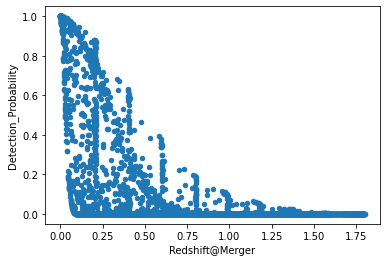

In [45]:
LIGOcatalog_df.plot.scatter(x='Redshift@Merger', y='Detection_Probability')

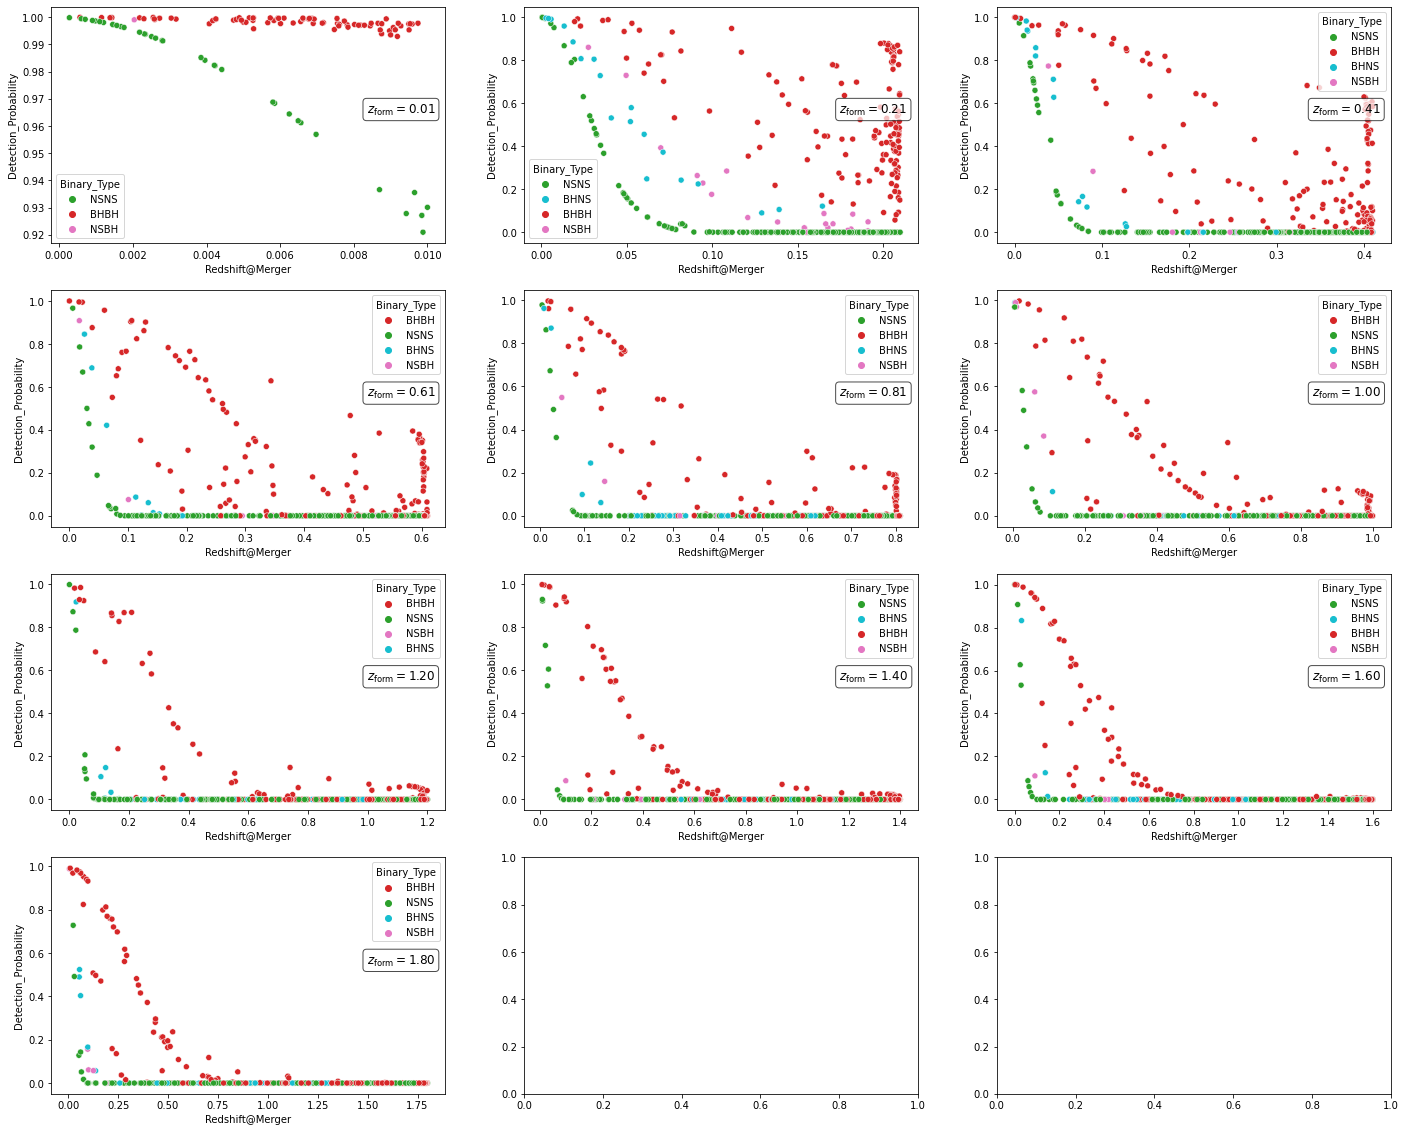

In [46]:
fig, axes = plt.subplots(4, 3, figsize=(24,20))
axes = axes.flatten()
props = dict(boxstyle='round', facecolor='white', alpha=0.7)

for i, ax in enumerate(axes):
    try:
        z = formation_redshifts[i]
        subcatalog = LIGOcatalog_df[LIGOcatalog_df['Redshift@ZAMS'] == z]
        sns.scatterplot(data=subcatalog, x='Redshift@Merger', y='Detection_Probability', ax=ax, hue='Binary_Type', palette=sns_palette)
        ax.text(0.8, 0.55, r'$z_\mathrm{form}=%.2f$' % z, fontsize=12, transform=ax.transAxes, bbox=props)
    except IndexError:
        continue

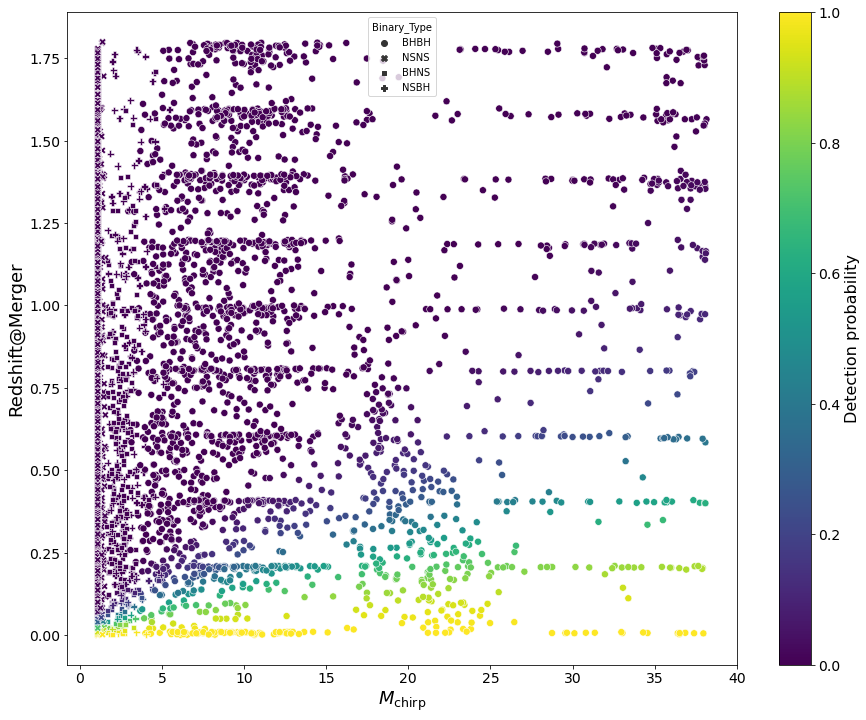

In [47]:
Z = LIGOcatalog_df['Detection_Probability'].to_numpy()
color_norm = max(Z) - min(Z)


fig, ax = plt.subplots(figsize=(15,12))

sns.scatterplot(data=LIGOcatalog_df, x='Chirp_Mass', y='Redshift@Merger', c=Z, cmap='viridis', vmin=Z.min(), vmax=Z.max(), s=50, ax=ax, style='Binary_Type')

ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'$M_\mathrm{chirp}$', fontsize=18)
ax.set_ylabel('Redshift@Merger', fontsize=18)

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=Z.min(), vmax=Z.max()))
cb = fig.colorbar(sm)

cb.set_label(label='Detection probability', size=16)
cb.ax.tick_params(labelsize=14)

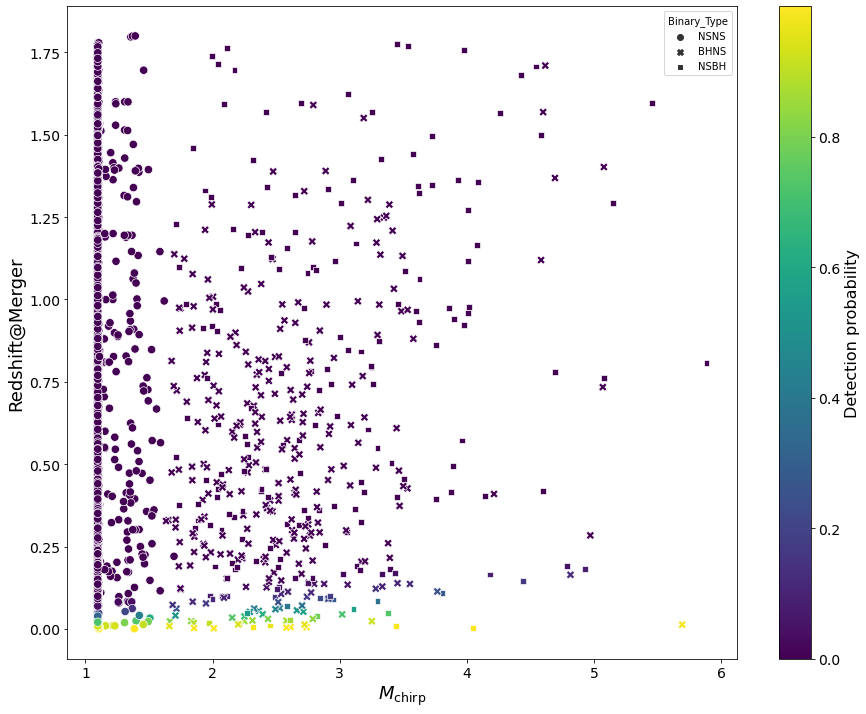

In [48]:
subcatalog = LIGOcatalog_df[LIGOcatalog_df.Binary_Type != 'BHBH']
Z = subcatalog['Detection_Probability'].to_numpy()
color_norm = max(Z) - min(Z)

fig, ax = plt.subplots(figsize=(15,12))


sns.scatterplot(data=subcatalog, x='Chirp_Mass', y='Redshift@Merger', c=Z, cmap='viridis', vmin=Z.min(), vmax=Z.max(), s=70, ax=ax, style='Binary_Type')

ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'$M_\mathrm{chirp}$', fontsize=18)
ax.set_ylabel('Redshift@Merger', fontsize=18)

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=Z.min(), vmax=Z.max()))
cb = fig.colorbar(sm)

cb.set_label(label='Detection probability', size=16)
cb.ax.tick_params(labelsize=14)

#### Defining the final c atalog

We can now choose a threshold detection probability and drop all systems with a lesser probability.

In [49]:
detection_threshold = 0.1

finalcatalog_df = LIGOcatalog_df[LIGOcatalog_df.Detection_Probability >= detection_threshold]

This should help create the kinds of correlations between redshift and other quantities that are expected. Let's check.

In [50]:
finalcatalog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 821 entries, 0 to 5828
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SEED                   821 non-null    uint64 
 1   Mass(1)                821 non-null    float64
 2   Mass(2)                821 non-null    float64
 3   Coalescence_Time       821 non-null    float64
 4   Metallicity@ZAMS(1)    821 non-null    float64
 5   Redshift@ZAMS          821 non-null    float64
 6   Binary_Type            821 non-null    object 
 7   Chirp_Mass             821 non-null    float64
 8   Total_Mass@DCO         821 non-null    float64
 9   Mass_Ratio@DCO         821 non-null    float64
 10  Merger_Time            821 non-null    float64
 11  Redshift@Merger        821 non-null    float64
 12  Fraction_to_Merge      821 non-null    float64
 13  Luminosity_Distance    821 non-null    float64
 14  Detection_Probability  821 non-null    float64
dtypes: fl

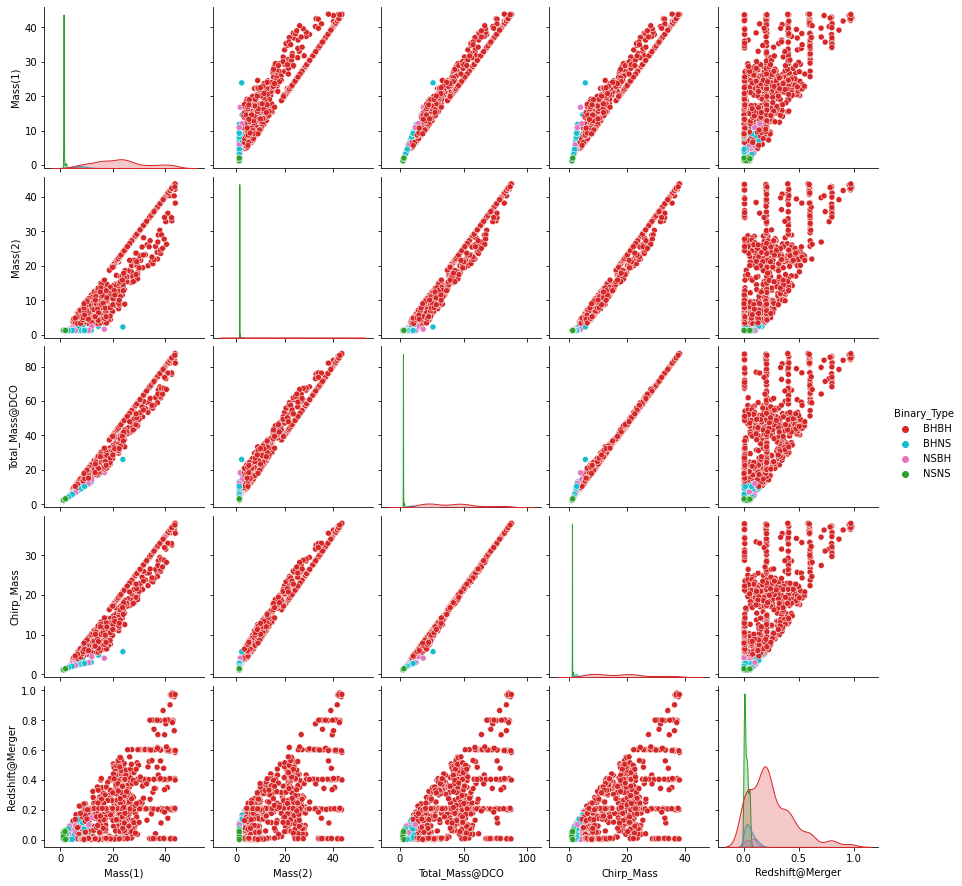

In [51]:
columns_to_plot = classification_columns+['Binary_Type']
sns.pairplot(finalcatalog_df[columns_to_plot], hue='Binary_Type', palette=sns_palette)

Implementing selection effects introduces a clear relation between redshift and mass. Notice how even imposing a minimum detection probability of 10% is enough to introduce the relation. But we might consider a higher threshold more adequate; for example, 50%. In this case,

In [52]:
detection_threshold = 0.5

finalcatalog_df = LIGOcatalog_df[LIGOcatalog_df.Detection_Probability >= detection_threshold]

This should help create the kinds of correlations between redshift and other quantities that are expected. Let's check.

In [53]:
finalcatalog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 55 to 5828
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SEED                   457 non-null    uint64 
 1   Mass(1)                457 non-null    float64
 2   Mass(2)                457 non-null    float64
 3   Coalescence_Time       457 non-null    float64
 4   Metallicity@ZAMS(1)    457 non-null    float64
 5   Redshift@ZAMS          457 non-null    float64
 6   Binary_Type            457 non-null    object 
 7   Chirp_Mass             457 non-null    float64
 8   Total_Mass@DCO         457 non-null    float64
 9   Mass_Ratio@DCO         457 non-null    float64
 10  Merger_Time            457 non-null    float64
 11  Redshift@Merger        457 non-null    float64
 12  Fraction_to_Merge      457 non-null    float64
 13  Luminosity_Distance    457 non-null    float64
 14  Detection_Probability  457 non-null    float64
dtypes: f

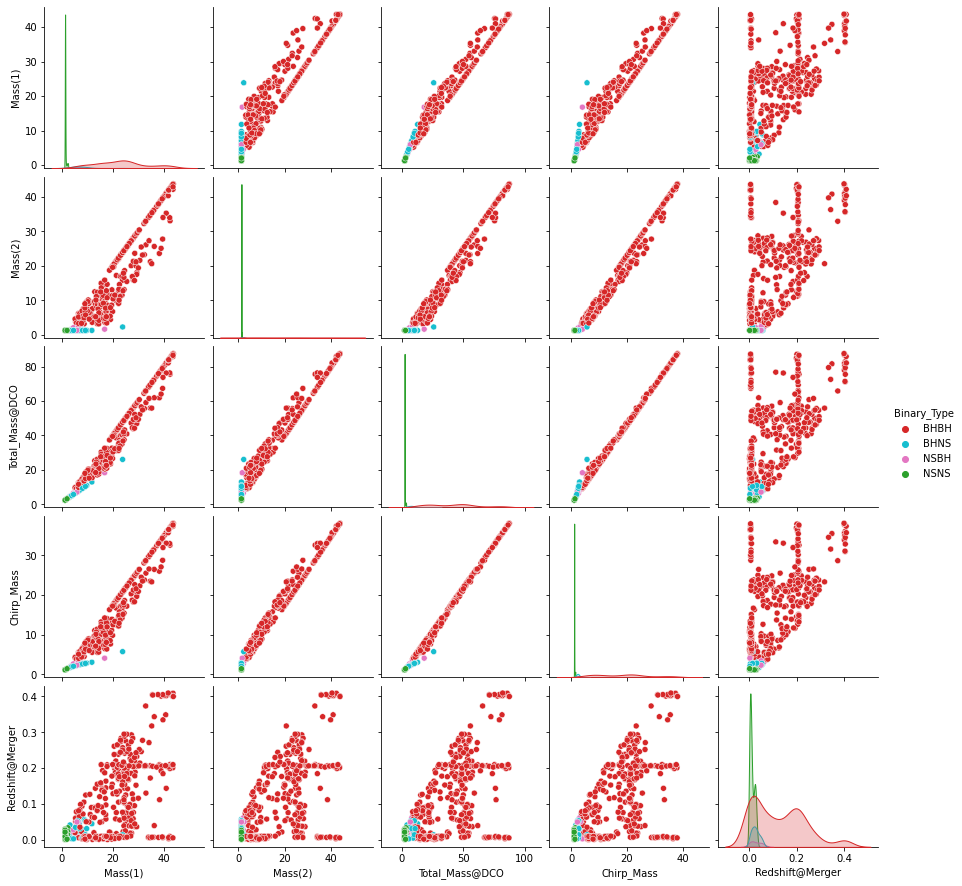

In [54]:
columns_to_plot = classification_columns+['Binary_Type']
sns.pairplot(finalcatalog_df[columns_to_plot], hue='Binary_Type', palette=sns_palette)

## Saving the data

Lastly, we need will save the final catalog in three separate files, one for each kind of binary (BHNSs and NSBHs counting as the same), that can be read by the classification notebook.

In [55]:
BHBH_df = finalcatalog_df[finalcatalog_df.Binary_Type == 'BHBH']
BHNS_df = finalcatalog_df[finalcatalog_df.Binary_Type == 'BHNS']
NSBH_df = finalcatalog_df[finalcatalog_df.Binary_Type == 'NSBH']
NSNS_df = finalcatalog_df[finalcatalog_df.Binary_Type == 'NSNS']
agnostic_BHNS_df = finalcatalog_df[np.logical_or(finalcatalog_df.Binary_Type == 'BHNS',
                                                 finalcatalog_df.Binary_Type == 'NSBH')
                                  ]

BHBH_df.reset_index(drop=True, inplace=True)
BHNS_df.reset_index(drop=True, inplace=True)
NSBH_df.reset_index(drop=True, inplace=True)
NSNS_df.reset_index(drop=True, inplace=True)
agnostic_BHNS_df.reset_index(drop=True, inplace=True)

In [56]:
ROOT = Path('.', 'ClassifierOutput')

In [57]:
file_columns = ['SEED']+classification_columns

In [58]:
filepath = Path(ROOT, 'BHBH_catalog.txt')

df = BHBH_df[file_columns]
df.to_csv(filepath, index=True, header='True', sep=' ')

In [59]:
filepath = Path(ROOT, 'BHNS_catalog.txt')

df = agnostic_BHNS_df[file_columns]
df.to_csv(filepath, index=True, header='True', sep=' ')

In [60]:
filepath = Path(ROOT, 'NSNS_catalog.txt')

df = NSNS_df[file_columns]
df.to_csv(filepath, index=True, header='True', sep=' ')

## Sorting the data

Because it is convenient to have that data already sorted by mass, we can load the three files we have just created, sort them by $ M_1 $, and then save them again.

In [61]:
HEADER = 'SEED M1 M2 M_total M_chirp Redshift'

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


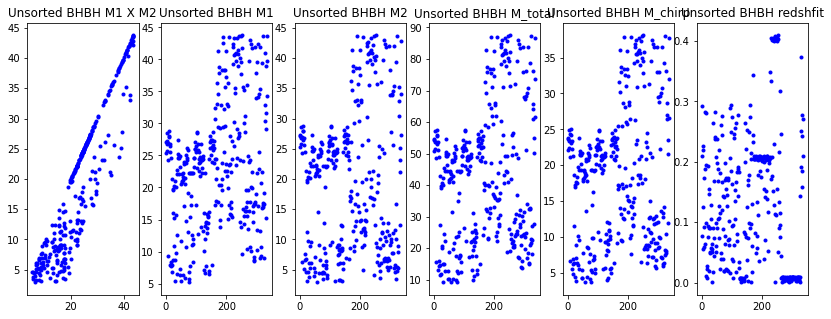

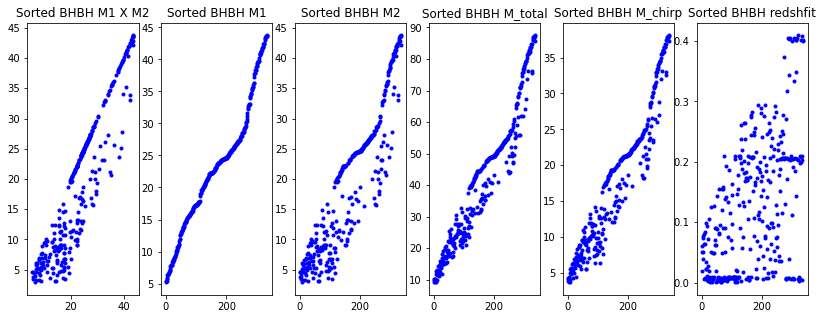

In [62]:
FILE = Path(ROOT, 'BHBH_catalog.txt')
NEW_FILE = Path(ROOT, 'sortedBHBH_catalog.txt')

index, seed_unsorted, m1_unsorted, m2_unsorted, m_total_unsorted, m_chirp_unsorted, redshift_unsorted = np.loadtxt(FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_unsorted, m2_unsorted, 'b.')
ax1.set_title('Unsorted BHBH M1 X M2')
ax2.plot(m1_unsorted, 'b.')
ax2.set_title('Unsorted BHBH M1')
ax3.plot(m2_unsorted, 'b.')
ax3.set_title('Unsorted BHBH M2')
ax4.plot(m_total_unsorted, 'b.')
ax4.set_title('Unsorted BHBH M_total')
ax5.plot(m_chirp_unsorted, 'b.')
ax5.set_title('Unsorted BHBH M_chirp')
ax6.plot(redshift_unsorted, 'b.')
ax6.set_title('Unsorted BHBH redshfit')

fig.show()

sorted_m1_indexes = np.argsort(m1_unsorted)
seed_sorted = np.array([seed_unsorted[index] for index in sorted_m1_indexes])
m1_sorted = np.array([m1_unsorted[index] for index in sorted_m1_indexes])
m2_sorted = np.array([m2_unsorted[index] for index in sorted_m1_indexes])
m_total_sorted = np.array([m_total_unsorted[index] for index in sorted_m1_indexes])
m_chirp_sorted = np.array([m_chirp_unsorted[index] for index in sorted_m1_indexes])
redshift_sorted = np.array([redshift_unsorted[index] for index in sorted_m1_indexes])

sorted_array = np.array([index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted]).T

np.savetxt(NEW_FILE, sorted_array, header=HEADER, delimiter=' ')

index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted = np.loadtxt(NEW_FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_sorted, m2_sorted, 'b.')
ax1.set_title('Sorted BHBH M1 X M2')
ax2.plot(m1_sorted, 'b.')
ax2.set_title('Sorted BHBH M1')
ax3.plot(m2_sorted, 'b.')
ax3.set_title('Sorted BHBH M2')
ax4.plot(m_total_sorted, 'b.')
ax4.set_title('Sorted BHBH M_total')
ax5.plot(m_chirp_sorted, 'b.')
ax5.set_title('Sorted BHBH M_chirp')
ax6.plot(redshift_sorted, 'b.')
ax6.set_title('Sorted BHBH redshfit')

fig.show()

The figures above serve to show the difference between the sorted and unsorted arrays.

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


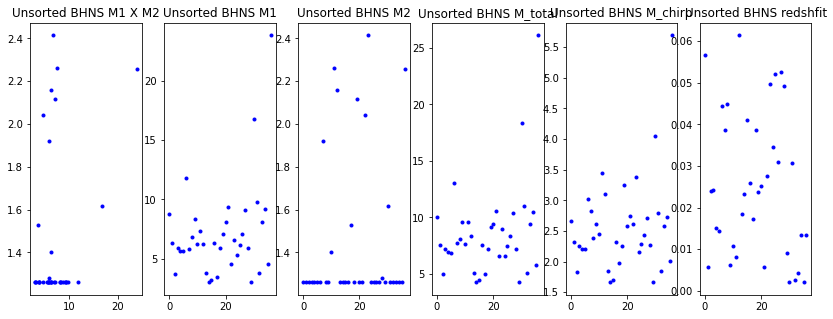

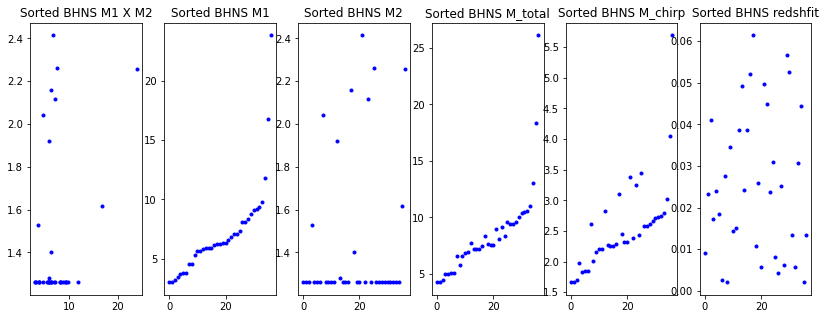

In [63]:
FILE = Path(ROOT, 'BHNS_catalog.txt')
NEW_FILE = Path(ROOT, 'sortedBHNS_catalog.txt')

index, seed_unsorted, m1_unsorted, m2_unsorted, m_total_unsorted, m_chirp_unsorted, redshift_unsorted = np.loadtxt(FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_unsorted, m2_unsorted, 'b.')
ax1.set_title('Unsorted BHNS M1 X M2')
ax2.plot(m1_unsorted, 'b.')
ax2.set_title('Unsorted BHNS M1')
ax3.plot(m2_unsorted, 'b.')
ax3.set_title('Unsorted BHNS M2')
ax4.plot(m_total_unsorted, 'b.')
ax4.set_title('Unsorted BHNS M_total')
ax5.plot(m_chirp_unsorted, 'b.')
ax5.set_title('Unsorted BHNS M_chirp')
ax6.plot(redshift_unsorted, 'b.')
ax6.set_title('Unsorted BHNS redshfit')

fig.show()

sorted_m1_indexes = np.argsort(m1_unsorted)
seed_sorted = np.array([seed_unsorted[index] for index in sorted_m1_indexes])
m1_sorted = np.array([m1_unsorted[index] for index in sorted_m1_indexes])
m2_sorted = np.array([m2_unsorted[index] for index in sorted_m1_indexes])
m_total_sorted = np.array([m_total_unsorted[index] for index in sorted_m1_indexes])
m_chirp_sorted = np.array([m_chirp_unsorted[index] for index in sorted_m1_indexes])
redshift_sorted = np.array([redshift_unsorted[index] for index in sorted_m1_indexes])

sorted_array = np.array([index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted]).T

np.savetxt(NEW_FILE, sorted_array, header=HEADER, delimiter=' ')

index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted = np.loadtxt(NEW_FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_sorted, m2_sorted, 'b.')
ax1.set_title('Sorted BHNS M1 X M2')
ax2.plot(m1_sorted, 'b.')
ax2.set_title('Sorted BHNS M1')
ax3.plot(m2_sorted, 'b.')
ax3.set_title('Sorted BHNS M2')
ax4.plot(m_total_sorted, 'b.')
ax4.set_title('Sorted BHNS M_total')
ax5.plot(m_chirp_sorted, 'b.')
ax5.set_title('Sorted BHNS M_chirp')
ax6.plot(redshift_sorted, 'b.')
ax6.set_title('Sorted BHNS redshfit')

fig.show()

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


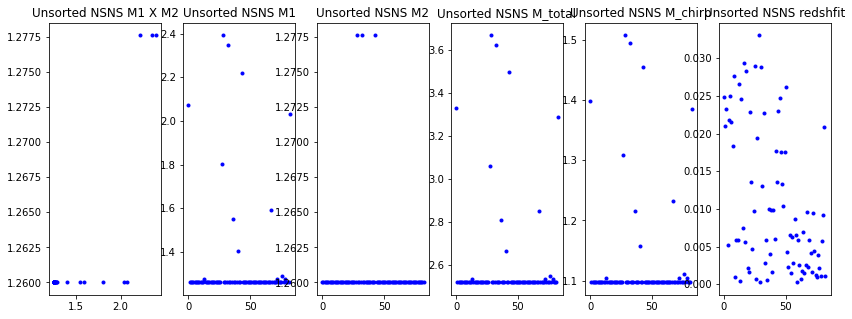

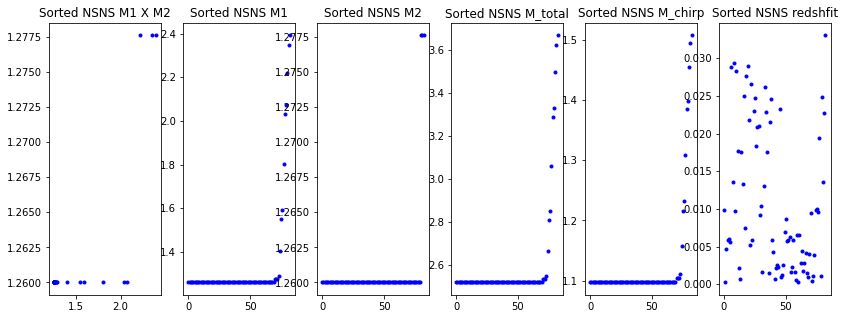

In [64]:
FILE = Path(ROOT, 'NSNS_catalog.txt')
NEW_FILE = Path(ROOT, 'sortedNSNS_catalog.txt')

index, seed_unsorted, m1_unsorted, m2_unsorted, m_total_unsorted, m_chirp_unsorted, redshift_unsorted = np.loadtxt(FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_unsorted, m2_unsorted, 'b.')
ax1.set_title('Unsorted NSNS M1 X M2')
ax2.plot(m1_unsorted, 'b.')
ax2.set_title('Unsorted NSNS M1')
ax3.plot(m2_unsorted, 'b.')
ax3.set_title('Unsorted NSNS M2')
ax4.plot(m_total_unsorted, 'b.')
ax4.set_title('Unsorted NSNS M_total')
ax5.plot(m_chirp_unsorted, 'b.')
ax5.set_title('Unsorted NSNS M_chirp')
ax6.plot(redshift_unsorted, 'b.')
ax6.set_title('Unsorted NSNS redshfit')

fig.show()

sorted_m1_indexes = np.argsort(m1_unsorted)
seed_sorted = np.array([seed_unsorted[index] for index in sorted_m1_indexes])
m1_sorted = np.array([m1_unsorted[index] for index in sorted_m1_indexes])
m2_sorted = np.array([m2_unsorted[index] for index in sorted_m1_indexes])
m_total_sorted = np.array([m_total_unsorted[index] for index in sorted_m1_indexes])
m_chirp_sorted = np.array([m_chirp_unsorted[index] for index in sorted_m1_indexes])
redshift_sorted = np.array([redshift_unsorted[index] for index in sorted_m1_indexes])

sorted_array = np.array([index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted]).T

np.savetxt(NEW_FILE, sorted_array, header=HEADER, delimiter=' ')

index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted = np.loadtxt(NEW_FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_sorted, m2_sorted, 'b.')
ax1.set_title('Sorted NSNS M1 X M2')
ax2.plot(m1_sorted, 'b.')
ax2.set_title('Sorted NSNS M1')
ax3.plot(m2_sorted, 'b.')
ax3.set_title('Sorted NSNS M2')
ax4.plot(m_total_sorted, 'b.')
ax4.set_title('Sorted NSNS M_total')
ax5.plot(m_chirp_sorted, 'b.')
ax5.set_title('Sorted NSNS M_chirp')
ax6.plot(redshift_sorted, 'b.')
ax6.set_title('Sorted NSNS redshfit')

fig.show()